In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import mlflow
import mlflow.sklearn

In [3]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from src.features.extract_features import *
from src.data.dataset import *

In [5]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,3)
plt.rcParams["figure.max_open_warning"] = False
data_files = glob.glob(r"D:\Hagar\Downloads\data\*\*")

In [6]:
# for file in data_files:
#     data = pd.read_csv(file)
    
#     ch1_mean = data.Channel1.mean()
#     ch2_mean = data.Channel2.mean()
#     data.Channel1 = data.Channel1.apply(lambda x: x - ch1_mean)
#     data.Channel2 = data.Channel2.apply(lambda x: x - ch2_mean)
    
    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     subject = file.split("\\")[-2]
#     gesture = file.split("\\")[-1]
#     fig.suptitle(subject + gesture)
#     samples = np.arange(len(data.Channel1))
#     sns.lineplot(data = data, x=samples, y = "Channel1", hue = "Label", ax=ax1)
#     sns.lineplot(data = data, x=samples, y = "Channel2", hue = "Label", ax=ax2)

In [20]:
from datetime import datetime
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow import keras
from keras import Sequential, layers, initializers, optimizers, losses

data_dir = r"C:\Users\Hagar\Desktop\Dataset\data"

def generate_dataset(data_dir, feature_set, win_size, win_stride, is_td=True):
    start = datetime.now()
    dataset = EmgDataset(data_dir, win_size, win_stride, feature_set, is_td)
    end = datetime.now()
    
    print("Feature Extraction Time per Window: ", ((end-start).total_seconds()*1000)/dataset.extracted_features.shape[0])
    
    emg_features = dataset.extracted_features
    labels = dataset.rolled_labels
    reps = dataset.rolled_repetition
    
    train_rows = np.isin(reps, ['1','3','4']).ravel()
    test_rows = np.isin(reps, ['2']).ravel()

    train_emg = emg_features[train_rows]
    y_train = labels[train_rows].ravel()

    test_emg = emg_features[test_rows]
    y_test = labels[test_rows].ravel()

    print(f"X_train shape: {train_emg.shape} y_train shape: {y_train.shape}")
    print(f"X_test shape: {test_emg.shape} y_test shape: {y_test.shape}")
    
    y_train = y_train[~np.isnan(train_emg).any(axis=1)]
    train_emg = train_emg[~np.isnan(train_emg).any(axis=1)]

    y_test = y_test[~np.isnan(test_emg).any(axis=1)]
    test_emg = test_emg[~np.isnan(test_emg).any(axis=1)]
    
    return train_emg, test_emg, y_train, y_test

def transform_dataset(train_emg, test_emg, y_train):
    undersampler = RandomUnderSampler(random_state=0)
    X_train_under, y_train_under = undersampler.fit_resample(train_emg, y_train)

    X_train, y_train = shuffle(X_train_under, y_train_under, random_state=0)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(test_emg)
    
    return X_train_scaled, X_test_scaled, y_train

def build_model():    
    model = Sequential()
    model.add(layers.Dense(512, kernel_initializer=initializers.HeNormal(), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256, kernel_initializer=initializers.HeNormal(), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256, kernel_initializer=initializers.HeNormal(), activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(6, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    
    return model

def evaluate_model(y_test, predictions):
    acc = accuracy_score(y_test, predictions.argmax(axis=1))
    balanced_acc = balanced_accuracy_score(y_test, predictions.argmax(axis=1))
    return acc, balanced_acc

def plot_results(y_test, predictions):
    print(classification_report(y_test, predictions.argmax(axis=1)))
    cm = confusion_matrix(y_test, predictions.argmax(axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    disp.plot(ax=ax)
    plt.show()

In [21]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [22]:
win_size = 200
win_stride = 50

In [23]:
feature_sets = []
accuracies = []
balanced_accuracies = []

## DNN w/ RMS

In [10]:
feature_set = ["rms"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 2) y_train shape: (72554,)
X_test shape: (31649, 2) y_test shape: (31649,)


In [11]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 10s 8ms/step - loss: 1.3282 - accuracy: 0.5288 - val_loss: 0.9536 - val_accuracy: 0.6839
Epoch 2/30
1157/1157 [==============================] - 12s 11ms/step - loss: 1.1905 - accuracy: 0.5598 - val_loss: 0.9713 - val_accuracy: 0.6658
Epoch 3/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.1585 - accuracy: 0.5609 - val_loss: 0.9490 - val_accuracy: 0.6692
Epoch 4/30
1157/1157 [==============================] - 12s 10ms/step - loss: 1.1355 - accuracy: 0.5692 - val_loss: 0.9438 - val_accuracy: 0.6655
Epoch 5/30
1157/1157 [==============================] - 12s 10ms/step - loss: 1.1206 - accuracy: 0.5747 - val_loss: 0.9434 - val_accuracy: 0.6656
Epoch 6/30
1157/1157 [==============================] - 11s 10ms/step - loss: 1.1058 - accuracy: 0.5778 - val_loss: 0.9440 - val_accuracy: 0.6567
Epoch 7/30
1157/1157 [==============================] - 8s 7ms/step - loss: 1.1008 - accuracy: 0.5821 - val_loss: 0.9291 - val_

Test Accuracy: 0.6644759708047647 Balanced Test Accuracy: 0.6234822969866917
              precision    recall  f1-score   support

           0       0.93      0.73      0.82     14741
           1       0.57      0.52      0.54      3679
           2       0.37      0.61      0.46      3000
           3       0.30      0.32      0.31      3197
           4       0.59      0.66      0.63      3243
           5       0.70      0.90      0.79      3789

    accuracy                           0.66     31649
   macro avg       0.58      0.62      0.59     31649
weighted avg       0.71      0.66      0.68     31649



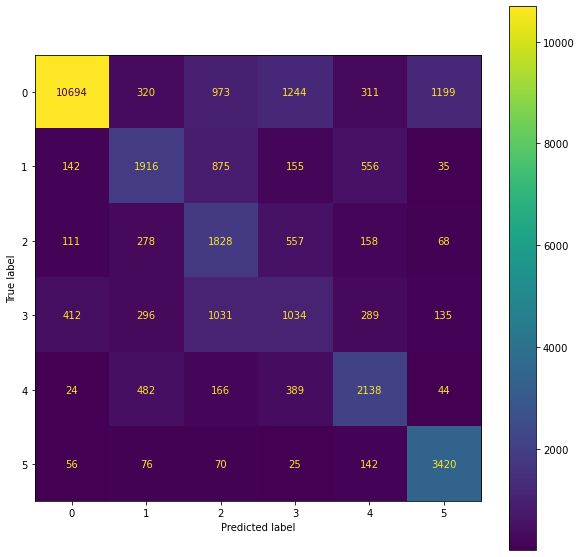

In [12]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [13]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms']] [0.6644759708047647] [0.6234822969866917]


## DNN w/ ZC/SSC/WL

In [14]:
feature_set = ["zc", "ssc", "wl"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 6) y_train shape: (72554,)
X_test shape: (31649, 6) y_test shape: (31649,)


In [15]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 7s 5ms/step - loss: 1.0540 - accuracy: 0.6032 - val_loss: 0.7167 - val_accuracy: 0.7256
Epoch 2/30
1157/1157 [==============================] - 9s 8ms/step - loss: 0.9313 - accuracy: 0.6366 - val_loss: 0.7180 - val_accuracy: 0.7271
Epoch 3/30
1157/1157 [==============================] - 9s 7ms/step - loss: 0.9027 - accuracy: 0.6454 - val_loss: 0.6925 - val_accuracy: 0.7361
Epoch 4/30
1157/1157 [==============================] - 12s 10ms/step - loss: 0.8945 - accuracy: 0.6488 - val_loss: 0.7205 - val_accuracy: 0.7264
Epoch 5/30
1157/1157 [==============================] - 11s 9ms/step - loss: 0.8884 - accuracy: 0.6510 - val_loss: 0.7341 - val_accuracy: 0.7240
Epoch 6/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.8706 - accuracy: 0.6566 - val_loss: 0.7304 - val_accuracy: 0.7238
Epoch 7/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.8673 - accuracy: 0.6578 - val_loss: 0.6755 - val_accura

Test Accuracy: 0.7327245726563241 Balanced Test Accuracy: 0.6546134173887808
              precision    recall  f1-score   support

           0       0.95      0.85      0.90     14741
           1       0.55      0.57      0.56      3679
           2       0.35      0.51      0.42      3000
           3       0.32      0.29      0.30      3197
           4       0.72      0.75      0.73      3243
           5       0.93      0.96      0.94      3789

    accuracy                           0.73     31649
   macro avg       0.64      0.65      0.64     31649
weighted avg       0.76      0.73      0.74     31649



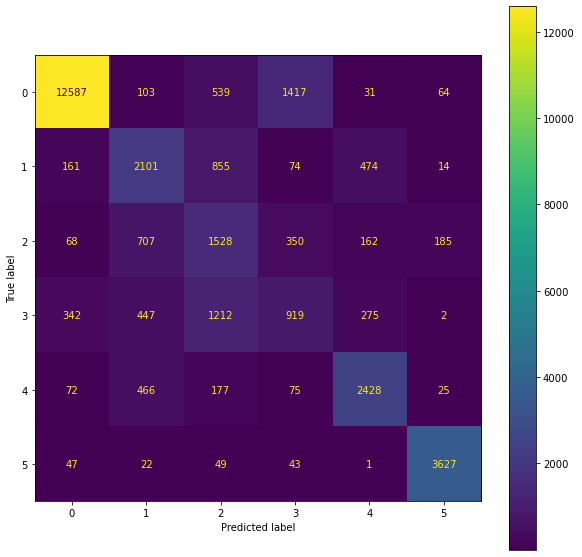

In [16]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [17]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl']] [0.6644759708047647, 0.7327245726563241] [0.6234822969866917, 0.6546134173887808]


## DNN w/ ZC/SSC/WL + MAV (Hudgins)

In [18]:
feature_set = ["zc", "ssc", "wl", "mav"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 8) y_train shape: (72554,)
X_test shape: (31649, 8) y_test shape: (31649,)


In [19]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.0502 - accuracy: 0.6153 - val_loss: 0.7201 - val_accuracy: 0.7313
Epoch 2/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.9072 - accuracy: 0.6516 - val_loss: 0.6988 - val_accuracy: 0.7431
Epoch 3/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8614 - accuracy: 0.6659 - val_loss: 0.7452 - val_accuracy: 0.7226
Epoch 4/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8423 - accuracy: 0.6715 - val_loss: 0.7213 - val_accuracy: 0.7329
Epoch 5/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8253 - accuracy: 0.6756 - val_loss: 0.7452 - val_accuracy: 0.7281
Epoch 6/30
1157/1157 [==============================] - 10s 9ms/step - loss: 0.8033 - accuracy: 0.6849 - val_loss: 0.7071 - val_accuracy: 0.7391
Epoch 7/30
1157/1157 [==============================] - 12s 10ms/step - loss: 0.7997 - accuracy: 0.6855 - val_loss: 0.7053 - val_accura

Test Accuracy: 0.7625833359663813 Balanced Test Accuracy: 0.6962620102471676
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     14741
           1       0.61      0.65      0.63      3679
           2       0.43      0.44      0.43      3000
           3       0.37      0.54      0.44      3197
           4       0.86      0.73      0.79      3243
           5       0.94      0.95      0.95      3789

    accuracy                           0.76     31649
   macro avg       0.69      0.70      0.69     31649
weighted avg       0.79      0.76      0.77     31649



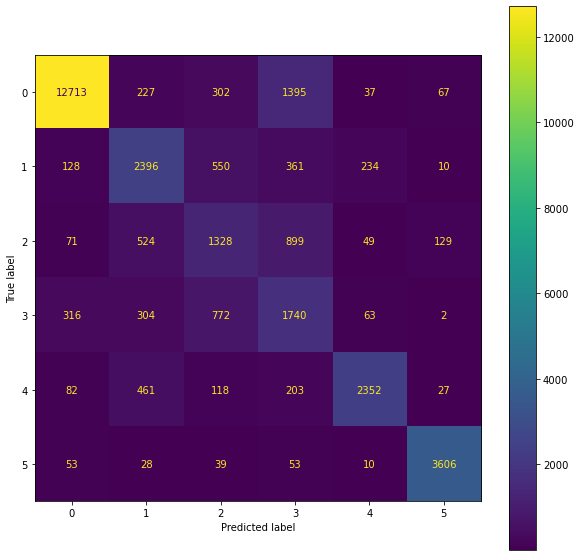

In [20]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [21]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav']] [0.6644759708047647, 0.7327245726563241, 0.7625833359663813] [0.6234822969866917, 0.6546134173887808, 0.6962620102471676]


## DNN w/ ZC/SSC/WL + RMS

In [22]:
feature_set = ["zc", "ssc", "wl", "rms"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 8) y_train shape: (72554,)
X_test shape: (31649, 8) y_test shape: (31649,)


In [23]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 8s 7ms/step - loss: 1.0488 - accuracy: 0.6116 - val_loss: 0.7064 - val_accuracy: 0.7335
Epoch 2/30
1157/1157 [==============================] - 11s 9ms/step - loss: 0.9084 - accuracy: 0.6523 - val_loss: 0.7275 - val_accuracy: 0.7353
Epoch 3/30
1157/1157 [==============================] - 9s 8ms/step - loss: 0.8667 - accuracy: 0.6642 - val_loss: 0.7153 - val_accuracy: 0.7389
Epoch 4/30
1157/1157 [==============================] - 10s 8ms/step - loss: 0.8347 - accuracy: 0.6772 - val_loss: 0.7176 - val_accuracy: 0.7383
Epoch 5/30
1157/1157 [==============================] - 10s 9ms/step - loss: 0.8156 - accuracy: 0.6828 - val_loss: 0.6928 - val_accuracy: 0.7497
Epoch 6/30
1157/1157 [==============================] - 10s 9ms/step - loss: 0.7992 - accuracy: 0.6888 - val_loss: 0.7019 - val_accuracy: 0.7449
Epoch 7/30
1157/1157 [==============================] - 10s 8ms/step - loss: 0.7913 - accuracy: 0.6926 - val_loss: 0.7070 - val_accu

Test Accuracy: 0.7677019811052482 Balanced Test Accuracy: 0.7056819054186084
              precision    recall  f1-score   support

           0       0.95      0.86      0.91     14741
           1       0.59      0.67      0.63      3679
           2       0.46      0.53      0.49      3000
           3       0.40      0.47      0.43      3197
           4       0.79      0.75      0.77      3243
           5       0.91      0.95      0.93      3789

    accuracy                           0.77     31649
   macro avg       0.69      0.71      0.69     31649
weighted avg       0.79      0.77      0.78     31649



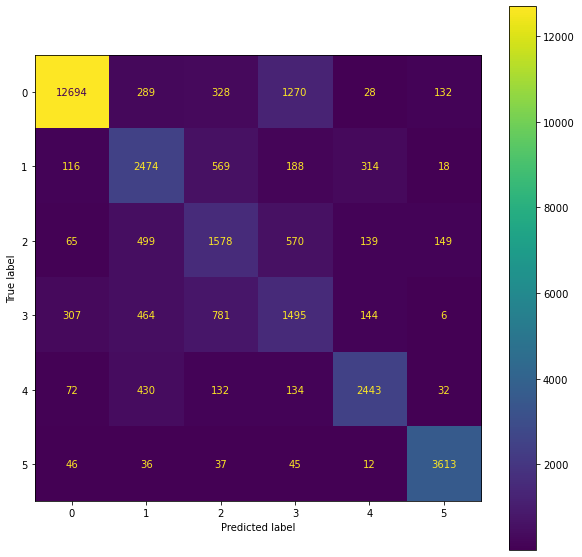

In [24]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [25]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms']] [0.6644759708047647, 0.7327245726563241, 0.7625833359663813, 0.7677019811052482] [0.6234822969866917, 0.6546134173887808, 0.6962620102471676, 0.7056819054186084]


## DNN w/ ZC/SSC/WL + VAR

In [26]:
feature_set = ["zc", "ssc", "wl", "var"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 8) y_train shape: (72554,)
X_test shape: (31649, 8) y_test shape: (31649,)


In [27]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 8s 6ms/step - loss: 1.0200 - accuracy: 0.6226 - val_loss: 0.7043 - val_accuracy: 0.7445
Epoch 2/30
1157/1157 [==============================] - 11s 10ms/step - loss: 0.8894 - accuracy: 0.6571 - val_loss: 0.6705 - val_accuracy: 0.7465
Epoch 3/30
1157/1157 [==============================] - 11s 9ms/step - loss: 0.8552 - accuracy: 0.6668 - val_loss: 0.6826 - val_accuracy: 0.7423
Epoch 4/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.8375 - accuracy: 0.6741 - val_loss: 0.6877 - val_accuracy: 0.7389
Epoch 5/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.8158 - accuracy: 0.6847 - val_loss: 0.6609 - val_accuracy: 0.7483
Epoch 6/30
1157/1157 [==============================] - 10s 9ms/step - loss: 0.8090 - accuracy: 0.6852 - val_loss: 0.6782 - val_accuracy: 0.7437
Epoch 7/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.7985 - accuracy: 0.6918 - val_loss: 0.6906 - val_accur

Test Accuracy: 0.7669120667319662 Balanced Test Accuracy: 0.7009100500335649
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     14741
           1       0.57      0.66      0.61      3679
           2       0.43      0.55      0.48      3000
           3       0.42      0.40      0.41      3197
           4       0.78      0.78      0.78      3243
           5       0.93      0.95      0.94      3789

    accuracy                           0.77     31649
   macro avg       0.68      0.70      0.69     31649
weighted avg       0.79      0.77      0.77     31649



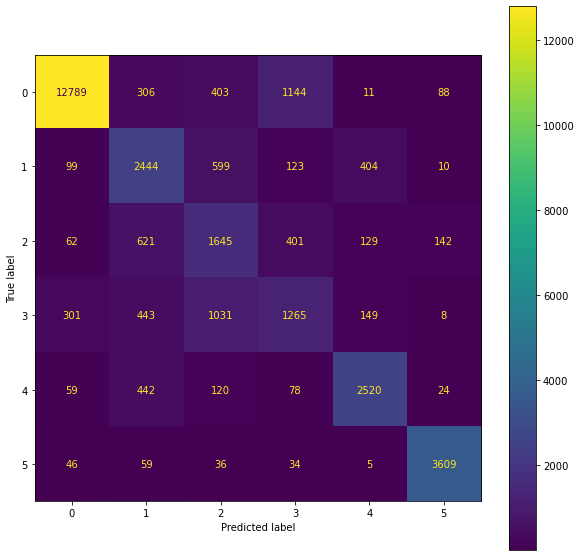

In [28]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [29]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var']] [0.6644759708047647, 0.7327245726563241, 0.7625833359663813, 0.7677019811052482, 0.7669120667319662] [0.6234822969866917, 0.6546134173887808, 0.6962620102471676, 0.7056819054186084, 0.7009100500335649]


## DNN w/ ZC/SSC/WL + MAV + RMS

In [30]:
feature_set = ["zc", "ssc", "wl", "mav", "rms"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 10) y_train shape: (72554,)
X_test shape: (31649, 10) y_test shape: (31649,)


In [31]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 6s 5ms/step - loss: 1.0470 - accuracy: 0.6105 - val_loss: 0.6756 - val_accuracy: 0.7483
Epoch 2/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.8858 - accuracy: 0.6600 - val_loss: 0.6927 - val_accuracy: 0.7405
Epoch 3/30
1157/1157 [==============================] - 5s 5ms/step - loss: 0.8454 - accuracy: 0.6719 - val_loss: 0.6965 - val_accuracy: 0.7410
Epoch 4/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.8218 - accuracy: 0.6840 - val_loss: 0.6709 - val_accuracy: 0.7523
Epoch 5/30
1157/1157 [==============================] - 5s 5ms/step - loss: 0.7914 - accuracy: 0.6951 - val_loss: 0.6941 - val_accuracy: 0.7477
Epoch 6/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.7846 - accuracy: 0.6969 - val_loss: 0.6809 - val_accuracy: 0.7533
Epoch 7/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.7647 - accuracy: 0.7057 - val_loss: 0.6177 - val_accuracy:

Test Accuracy: 0.787386647287434 Balanced Test Accuracy: 0.7275749797206159
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     14741
           1       0.63      0.69      0.66      3679
           2       0.48      0.57      0.52      3000
           3       0.45      0.53      0.48      3197
           4       0.82      0.75      0.78      3243
           5       0.94      0.95      0.95      3789

    accuracy                           0.79     31649
   macro avg       0.71      0.73      0.72     31649
weighted avg       0.81      0.79      0.80     31649



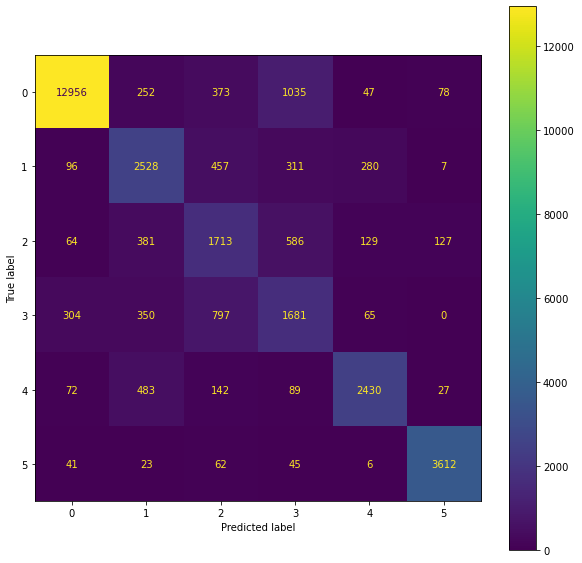

In [32]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [33]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms']] [0.6644759708047647, 0.7327245726563241, 0.7625833359663813, 0.7677019811052482, 0.7669120667319662, 0.787386647287434] [0.6234822969866917, 0.6546134173887808, 0.6962620102471676, 0.7056819054186084, 0.7009100500335649, 0.7275749797206159]


## DNN w/ ZC/SSC/WL + MAV + VAR

In [34]:
feature_set = ["zc", "ssc", "wl", "mav", "var"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 10) y_train shape: (72554,)
X_test shape: (31649, 10) y_test shape: (31649,)


In [35]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 8s 6ms/step - loss: 1.0449 - accuracy: 0.6127 - val_loss: 0.7531 - val_accuracy: 0.7241
Epoch 2/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8925 - accuracy: 0.6546 - val_loss: 0.7568 - val_accuracy: 0.7161
Epoch 3/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8479 - accuracy: 0.6707 - val_loss: 0.7385 - val_accuracy: 0.7240
Epoch 4/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8266 - accuracy: 0.6771 - val_loss: 0.7095 - val_accuracy: 0.7515
Epoch 5/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8135 - accuracy: 0.6831 - val_loss: 0.6855 - val_accuracy: 0.7507
Epoch 6/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.7909 - accuracy: 0.6929 - val_loss: 0.7229 - val_accuracy: 0.7432
Epoch 7/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.7801 - accuracy: 0.6975 - val_loss: 0.6773 - val_accuracy:

Test Accuracy: 0.7779392713829821 Balanced Test Accuracy: 0.7235055676422003
              precision    recall  f1-score   support

           0       0.96      0.86      0.91     14741
           1       0.65      0.72      0.68      3679
           2       0.48      0.61      0.53      3000
           3       0.40      0.47      0.43      3197
           4       0.83      0.73      0.78      3243
           5       0.94      0.96      0.95      3789

    accuracy                           0.78     31649
   macro avg       0.71      0.72      0.71     31649
weighted avg       0.80      0.78      0.79     31649



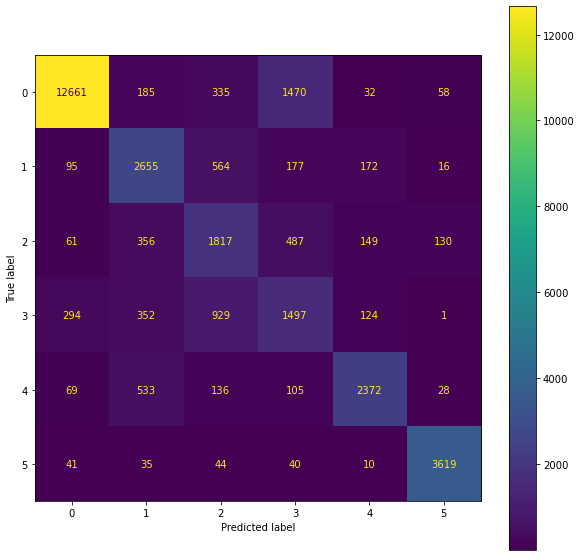

In [36]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [37]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var']] [0.6644759708047647, 0.7327245726563241, 0.7625833359663813, 0.7677019811052482, 0.7669120667319662, 0.787386647287434, 0.7779392713829821] [0.6234822969866917, 0.6546134173887808, 0.6962620102471676, 0.7056819054186084, 0.7009100500335649, 0.7275749797206159, 0.7235055676422003]


## DNN w/ ZC/SSC/WL + RMS + VAR

In [38]:
feature_set = ["zc", "ssc", "wl", "rms", "var"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 10) y_train shape: (72554,)
X_test shape: (31649, 10) y_test shape: (31649,)


In [39]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 7s 5ms/step - loss: 1.0467 - accuracy: 0.6158 - val_loss: 0.7332 - val_accuracy: 0.7290
Epoch 2/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.8936 - accuracy: 0.6592 - val_loss: 0.6702 - val_accuracy: 0.7563
Epoch 3/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.8512 - accuracy: 0.6707 - val_loss: 0.6652 - val_accuracy: 0.7551
Epoch 4/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.8255 - accuracy: 0.6818 - val_loss: 0.6955 - val_accuracy: 0.7470
Epoch 5/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.8076 - accuracy: 0.6868 - val_loss: 0.6623 - val_accuracy: 0.7639
Epoch 6/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.7879 - accuracy: 0.6940 - val_loss: 0.6694 - val_accuracy: 0.7610
Epoch 7/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.7731 - accuracy: 0.7023 - val_loss: 0.7033 - val_accuracy:

Test Accuracy: 0.7773073398843565 Balanced Test Accuracy: 0.7155166314553347
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     14741
           1       0.61      0.65      0.63      3679
           2       0.45      0.55      0.49      3000
           3       0.44      0.48      0.46      3197
           4       0.78      0.79      0.78      3243
           5       0.94      0.95      0.94      3789

    accuracy                           0.78     31649
   macro avg       0.70      0.72      0.70     31649
weighted avg       0.79      0.78      0.78     31649



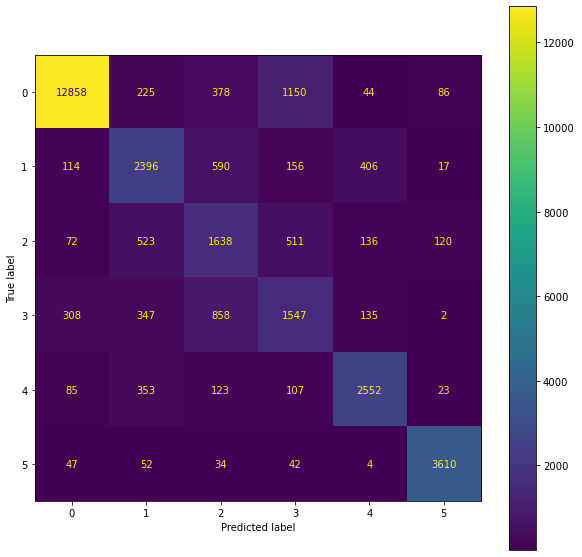

In [40]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [41]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var']] [0.6644759708047647, 0.7327245726563241, 0.7625833359663813, 0.7677019811052482, 0.7669120667319662, 0.787386647287434, 0.7779392713829821, 0.7773073398843565] [0.6234822969866917, 0.6546134173887808, 0.6962620102471676, 0.7056819054186084, 0.7009100500335649, 0.7275749797206159, 0.7235055676422003, 0.7155166314553347]


## DNN w/ ZC/SSC/WL + MAV + RMS + VAR

In [42]:
feature_set = ["zc", "ssc", "wl", "mav", "rms", "var"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 12) y_train shape: (72554,)
X_test shape: (31649, 12) y_test shape: (31649,)


In [43]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 7s 5ms/step - loss: 1.0469 - accuracy: 0.6152 - val_loss: 0.6769 - val_accuracy: 0.7525
Epoch 2/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.8838 - accuracy: 0.6612 - val_loss: 0.6708 - val_accuracy: 0.7500
Epoch 3/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.8498 - accuracy: 0.6739 - val_loss: 0.6891 - val_accuracy: 0.7487
Epoch 4/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.8119 - accuracy: 0.6894 - val_loss: 0.6715 - val_accuracy: 0.7509
Epoch 5/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.7900 - accuracy: 0.6961 - val_loss: 0.6670 - val_accuracy: 0.7566
Epoch 6/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.7781 - accuracy: 0.7005 - val_loss: 0.6397 - val_accuracy: 0.7651
Epoch 7/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.7619 - accuracy: 0.7065 - val_loss: 0.6210 - val_accuracy:

Test Accuracy: 0.7898195835571424 Balanced Test Accuracy: 0.7333108558941959
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     14741
           1       0.63      0.72      0.67      3679
           2       0.51      0.51      0.51      3000
           3       0.44      0.55      0.49      3197
           4       0.82      0.79      0.80      3243
           5       0.94      0.96      0.95      3789

    accuracy                           0.79     31649
   macro avg       0.72      0.73      0.72     31649
weighted avg       0.81      0.79      0.80     31649



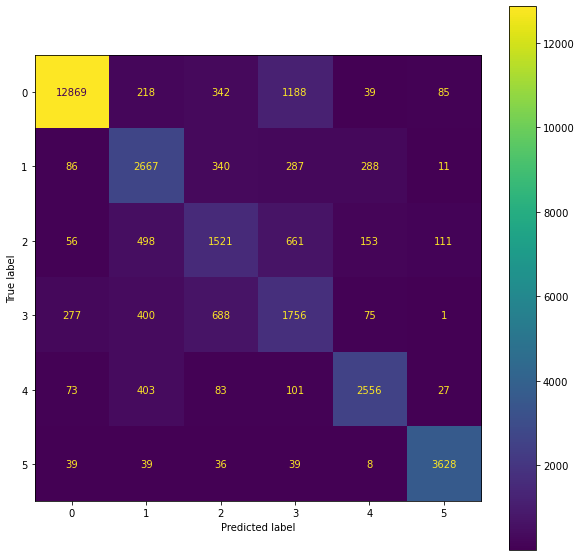

In [44]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [45]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var']] [0.6644759708047647, 0.7327245726563241, 0.7625833359663813, 0.7677019811052482, 0.7669120667319662, 0.787386647287434, 0.7779392713829821, 0.7773073398843565, 0.7898195835571424] [0.6234822969866917, 0.6546134173887808, 0.6962620102471676, 0.7056819054186084, 0.7009100500335649, 0.7275749797206159, 0.7235055676422003, 0.7155166314553347, 0.7333108558941959]


## DNN w/ ZC/SSC/WL + iEMG + VAR + WAMP (Du)

In [46]:
feature_set = ["zc", "ssc", "wl", "iemg", "var", "wamp"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 12) y_train shape: (72554,)
X_test shape: (31649, 12) y_test shape: (31649,)


In [47]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 7s 5ms/step - loss: 1.0430 - accuracy: 0.6153 - val_loss: 0.7561 - val_accuracy: 0.7179
Epoch 2/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.8900 - accuracy: 0.6549 - val_loss: 0.7387 - val_accuracy: 0.7246
Epoch 3/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.8522 - accuracy: 0.6700 - val_loss: 0.6999 - val_accuracy: 0.7418
Epoch 4/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.8282 - accuracy: 0.6762 - val_loss: 0.7005 - val_accuracy: 0.7361
Epoch 5/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.7997 - accuracy: 0.6878 - val_loss: 0.7577 - val_accuracy: 0.7197
Epoch 6/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.7897 - accuracy: 0.6896 - val_loss: 0.6492 - val_accuracy: 0.7588
Epoch 7/30
1157/1157 [==============================] - 6s 5ms/step - loss: 0.7784 - accuracy: 0.6948 - val_loss: 0.6653 - val_accuracy:

Test Accuracy: 0.783974217194856 Balanced Test Accuracy: 0.729459331341212
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     14741
           1       0.66      0.67      0.66      3679
           2       0.46      0.61      0.52      3000
           3       0.43      0.47      0.45      3197
           4       0.81      0.80      0.81      3243
           5       0.94      0.95      0.94      3789

    accuracy                           0.78     31649
   macro avg       0.71      0.73      0.72     31649
weighted avg       0.81      0.78      0.79     31649



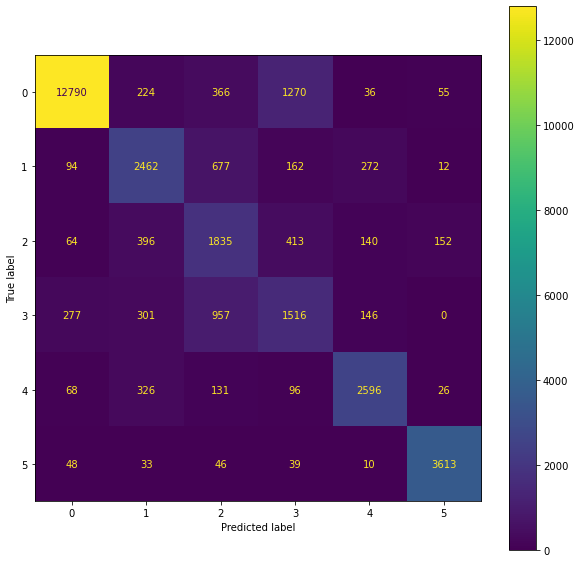

In [48]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [49]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var'], ['zc', 'ssc', 'wl', 'iemg', 'var', 'wamp']] [0.6644759708047647, 0.7327245726563241, 0.7625833359663813, 0.7677019811052482, 0.7669120667319662, 0.787386647287434, 0.7779392713829821, 0.7773073398843565, 0.7898195835571424, 0.783974217194856] [0.6234822969866917, 0.6546134173887808, 0.6962620102471676, 0.7056819054186084, 0.7009100500335649, 0.7275749797206159, 0.7235055676422003, 0.7155166314553347, 0.7333108558941959, 0.729459331341212]


## DNN w/ Skewness/RMS/iEMG/AR(P=11) + Hjorth

In [50]:
feature_set = ["skewness", "rms", "iemg", "ar_coeff", "hjorth"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 34) y_train shape: (72554,)
X_test shape: (31649, 34) y_test shape: (31649,)


In [51]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 8s 6ms/step - loss: 1.1694 - accuracy: 0.5802 - val_loss: 0.6516 - val_accuracy: 0.7713
Epoch 2/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.8813 - accuracy: 0.6752 - val_loss: 0.6350 - val_accuracy: 0.7754
Epoch 3/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.7962 - accuracy: 0.7049 - val_loss: 0.6144 - val_accuracy: 0.7835
Epoch 4/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.7481 - accuracy: 0.7244 - val_loss: 0.5963 - val_accuracy: 0.7924
Epoch 5/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.7060 - accuracy: 0.7389 - val_loss: 0.5784 - val_accuracy: 0.7980
Epoch 6/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.6749 - accuracy: 0.7519 - val_loss: 0.5811 - val_accuracy: 0.7964
Epoch 7/30
1157/1157 [==============================] - 7s 6ms/step - loss: 0.6499 - accuracy: 0.7586 - val_loss: 0.5699 - val_accuracy:

Test Accuracy: 0.8375568756319515 Balanced Test Accuracy: 0.8007535506579204
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     14740
           1       0.77      0.78      0.77      3679
           2       0.61      0.66      0.63      3000
           3       0.58      0.66      0.62      3197
           4       0.79      0.86      0.83      3243
           5       0.95      0.96      0.96      3789

    accuracy                           0.84     31648
   macro avg       0.78      0.80      0.79     31648
weighted avg       0.85      0.84      0.84     31648



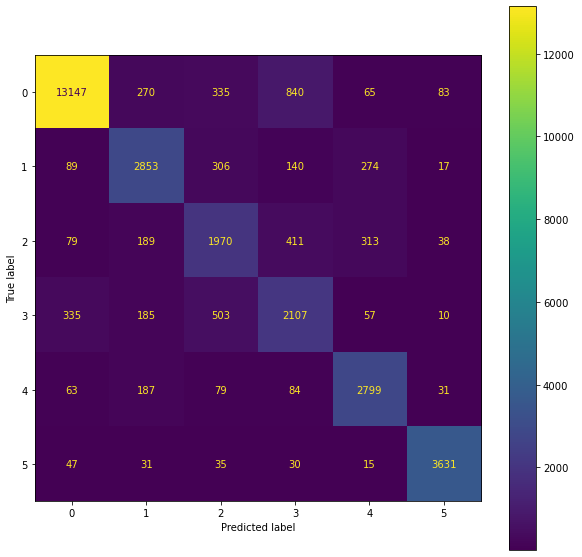

In [52]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [53]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var'], ['zc', 'ssc', 'wl', 'iemg', 'var', 'wamp'], ['skewness', 'rms', 'iemg', 'ar_coeff', 'hjorth']] [0.6644759708047647, 0.7327245726563241, 0.7625833359663813, 0.7677019811052482, 0.7669120667319662, 0.787386647287434, 0.7779392713829821, 0.7773073398843565, 0.7898195835571424, 0.783974217194856, 0.8375568756319515] [0.6234822969866917, 0.6546134173887808, 0.6962620102471676, 0.7056819054186084, 0.7009100500335649, 0.7275749797206159, 0.7235055676422003, 0.7155166314553347, 0.7333108558941959, 0.729459331341212, 0.8007535506579204]


## DNN w/ Frequency Domain Features (MNF/MDF/MMNF/MMDF)

In [54]:
feature_set = ["mnf", "mdf", "mmnf", "mmdf"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride, False)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 8) y_train shape: (72554,)
X_test shape: (31649, 8) y_test shape: (31649,)


In [55]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 8s 6ms/step - loss: 1.3912 - accuracy: 0.4975 - val_loss: 0.9013 - val_accuracy: 0.6693
Epoch 2/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.1779 - accuracy: 0.5536 - val_loss: 0.8548 - val_accuracy: 0.6811
Epoch 3/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.1134 - accuracy: 0.5751 - val_loss: 0.8593 - val_accuracy: 0.6797
Epoch 4/30
1157/1157 [==============================] - 6s 6ms/step - loss: 1.0779 - accuracy: 0.5853 - val_loss: 0.8403 - val_accuracy: 0.6874
Epoch 5/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.0519 - accuracy: 0.5927 - val_loss: 0.8413 - val_accuracy: 0.6864
Epoch 6/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.0328 - accuracy: 0.5999 - val_loss: 0.8347 - val_accuracy: 0.6923
Epoch 7/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.0129 - accuracy: 0.6107 - val_loss: 0.8076 - val_accuracy:

Test Accuracy: 0.7089639483080035 Balanced Test Accuracy: 0.6393443328084267
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     14741
           1       0.52      0.58      0.55      3679
           2       0.33      0.42      0.37      3000
           3       0.38      0.40      0.39      3197
           4       0.66      0.73      0.70      3243
           5       0.84      0.89      0.86      3789

    accuracy                           0.71     31649
   macro avg       0.61      0.64      0.62     31649
weighted avg       0.73      0.71      0.72     31649



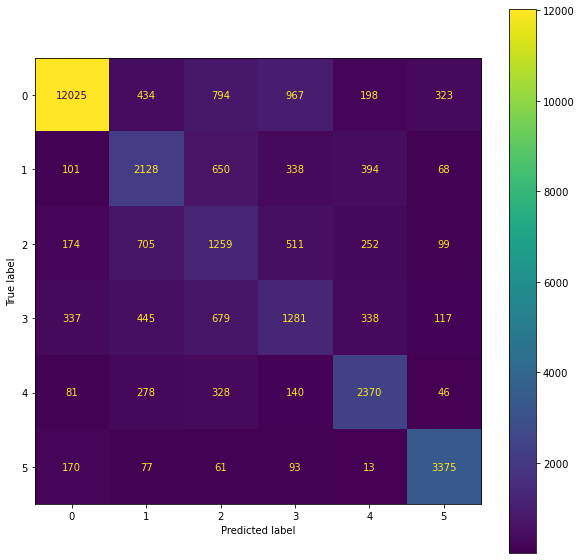

In [56]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [57]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var'], ['zc', 'ssc', 'wl', 'iemg', 'var', 'wamp'], ['skewness', 'rms', 'iemg', 'ar_coeff', 'hjorth'], ['mnf', 'mdf', 'mmnf', 'mmdf']] [0.6644759708047647, 0.7327245726563241, 0.7625833359663813, 0.7677019811052482, 0.7669120667319662, 0.787386647287434, 0.7779392713829821, 0.7773073398843565, 0.7898195835571424, 0.783974217194856, 0.8375568756319515, 0.7089639483080035] [0.6234822969866917, 0.6546134173887808, 0.6962620102471676, 0.7056819054186084, 0.7009100500335649, 0.7275749797206159, 0.7235055676422003, 0.7155166314553347, 0.7333108558941959, 0.729459331341212, 0.8007535506579204, 0.6393443328084267]


## DNN w/ MNF/MDF

In [58]:
feature_set = ["mnf", "mdf"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride, False)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 4) y_train shape: (72554,)
X_test shape: (31649, 4) y_test shape: (31649,)


In [59]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 8s 6ms/step - loss: 1.5637 - accuracy: 0.4312 - val_loss: 1.0818 - val_accuracy: 0.6038
Epoch 2/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.3855 - accuracy: 0.4726 - val_loss: 1.0714 - val_accuracy: 0.6161
Epoch 3/30
1157/1157 [==============================] - 6s 5ms/step - loss: 1.3277 - accuracy: 0.4920 - val_loss: 1.0726 - val_accuracy: 0.6144
Epoch 4/30
1157/1157 [==============================] - 6s 5ms/step - loss: 1.3018 - accuracy: 0.4981 - val_loss: 1.0456 - val_accuracy: 0.6228
Epoch 5/30
1157/1157 [==============================] - 6s 6ms/step - loss: 1.2782 - accuracy: 0.5051 - val_loss: 1.0650 - val_accuracy: 0.6167
Epoch 6/30
1157/1157 [==============================] - 6s 5ms/step - loss: 1.2565 - accuracy: 0.5133 - val_loss: 1.0371 - val_accuracy: 0.6258
Epoch 7/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.2532 - accuracy: 0.5149 - val_loss: 1.0664 - val_accuracy:

Test Accuracy: 0.6350911561186767 Balanced Test Accuracy: 0.5427326323139913
              precision    recall  f1-score   support

           0       0.88      0.78      0.83     14741
           1       0.43      0.58      0.49      3679
           2       0.25      0.28      0.26      3000
           3       0.28      0.24      0.26      3197
           4       0.58      0.62      0.60      3243
           5       0.68      0.77      0.72      3789

    accuracy                           0.64     31649
   macro avg       0.52      0.54      0.53     31649
weighted avg       0.65      0.64      0.64     31649



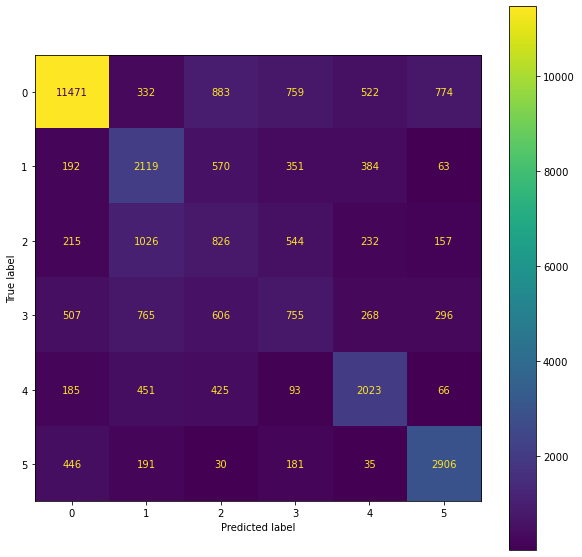

In [60]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [61]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var'], ['zc', 'ssc', 'wl', 'iemg', 'var', 'wamp'], ['skewness', 'rms', 'iemg', 'ar_coeff', 'hjorth'], ['mnf', 'mdf', 'mmnf', 'mmdf'], ['mnf', 'mdf']] [0.6644759708047647, 0.7327245726563241, 0.7625833359663813, 0.7677019811052482, 0.7669120667319662, 0.787386647287434, 0.7779392713829821, 0.7773073398843565, 0.7898195835571424, 0.783974217194856, 0.8375568756319515, 0.7089639483080035, 0.6350911561186767] [0.6234822969866917, 0.6546134173887808, 0.6962620102471676, 0.7056819054186084, 0.7009100500335649, 0.7275749797206159, 0.7235055676422003, 0.7155166314553347, 0.7333108558941959, 0.729459331341212, 0.8007535506579204, 0.6393443328084267, 0.5427326323139913]


## DNN w/ MMNF/MMDF

In [62]:
feature_set = ["mmnf", "mmdf"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride, False)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 4) y_train shape: (72554,)
X_test shape: (31649, 4) y_test shape: (31649,)


In [63]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 8s 6ms/step - loss: 1.5839 - accuracy: 0.4068 - val_loss: 1.3081 - val_accuracy: 0.4742
Epoch 2/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.4209 - accuracy: 0.4437 - val_loss: 1.2272 - val_accuracy: 0.5049
Epoch 3/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.3658 - accuracy: 0.4555 - val_loss: 1.2028 - val_accuracy: 0.5173
Epoch 4/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.3388 - accuracy: 0.4647 - val_loss: 1.1800 - val_accuracy: 0.5303
Epoch 5/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.3190 - accuracy: 0.4703 - val_loss: 1.1753 - val_accuracy: 0.5241
Epoch 6/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.3010 - accuracy: 0.4750 - val_loss: 1.1981 - val_accuracy: 0.5171
Epoch 7/30
1157/1157 [==============================] - 7s 6ms/step - loss: 1.2931 - accuracy: 0.4767 - val_loss: 1.1760 - val_accuracy:

Test Accuracy: 0.5327814464912004 Balanced Test Accuracy: 0.48405204279090097
              precision    recall  f1-score   support

           0       0.87      0.60      0.71     14741
           1       0.35      0.49      0.40      3679
           2       0.20      0.25      0.22      3000
           3       0.28      0.30      0.29      3197
           4       0.41      0.53      0.47      3243
           5       0.56      0.73      0.63      3789

    accuracy                           0.53     31649
   macro avg       0.45      0.48      0.46     31649
weighted avg       0.60      0.53      0.55     31649



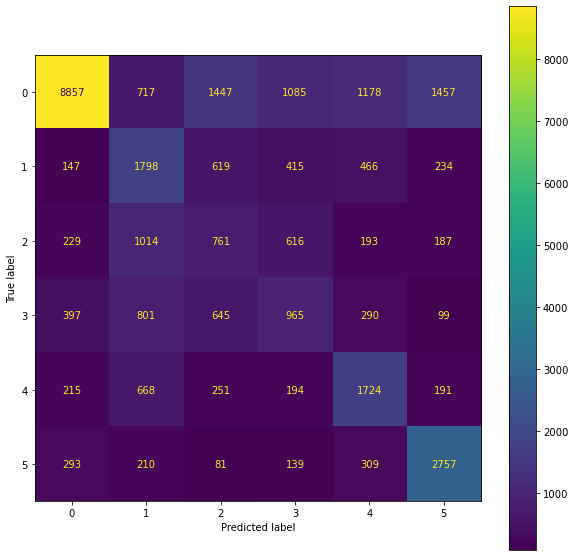

In [64]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [65]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var'], ['zc', 'ssc', 'wl', 'iemg', 'var', 'wamp'], ['skewness', 'rms', 'iemg', 'ar_coeff', 'hjorth'], ['mnf', 'mdf', 'mmnf', 'mmdf'], ['mnf', 'mdf'], ['mmnf', 'mmdf']] [0.6644759708047647, 0.7327245726563241, 0.7625833359663813, 0.7677019811052482, 0.7669120667319662, 0.787386647287434, 0.7779392713829821, 0.7773073398843565, 0.7898195835571424, 0.783974217194856, 0.8375568756319515, 0.7089639483080035, 0.6350911561186767, 0.5327814464912004] [0.6234822969866917, 0.6546134173887808, 0.6962620102471676, 0.7056819054186084, 0.7009100500335649, 0.7275749797206159, 0.7235055676422003, 0.7155166314553347, 0.7333108558941959, 0.729459331341212, 0.8007535506579204, 0.6393443328084267, 0.5427326323139913, 0.48405204279090097]


## DNN w/ Skewness/RMS/iEMG/AR(P=11) + Hjorth + MAV + ZC/SSC/WL

In [66]:
feature_set = ["skewness", "rms", "iemg", "ar_coeff", "hjorth", "mav", "zc", "ssc", "wl"]
feature_sets.append(feature_set)
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)
model = build_model()

X_train shape: (72554, 42) y_train shape: (72554,)
X_test shape: (31649, 42) y_test shape: (31649,)


In [67]:
model_hist = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks=[callback], epochs=30)

Epoch 1/30
1157/1157 [==============================] - 10s 7ms/step - loss: 1.1114 - accuracy: 0.5983 - val_loss: 0.6450 - val_accuracy: 0.7682
Epoch 2/30
1157/1157 [==============================] - 9s 8ms/step - loss: 0.8532 - accuracy: 0.6842 - val_loss: 0.6144 - val_accuracy: 0.7799
Epoch 3/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.7698 - accuracy: 0.7154 - val_loss: 0.5902 - val_accuracy: 0.7909
Epoch 4/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.7144 - accuracy: 0.7349 - val_loss: 0.5861 - val_accuracy: 0.7916
Epoch 5/30
1157/1157 [==============================] - 9s 7ms/step - loss: 0.6805 - accuracy: 0.7493 - val_loss: 0.5725 - val_accuracy: 0.7970
Epoch 6/30
1157/1157 [==============================] - 8s 7ms/step - loss: 0.6465 - accuracy: 0.7618 - val_loss: 0.5561 - val_accuracy: 0.8037
Epoch 7/30
1157/1157 [==============================] - 9s 7ms/step - loss: 0.6230 - accuracy: 0.7718 - val_loss: 0.5470 - val_accuracy

Test Accuracy: 0.8378096562184024 Balanced Test Accuracy: 0.8044760144632965
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     14740
           1       0.75      0.82      0.78      3679
           2       0.60      0.66      0.63      3000
           3       0.58      0.68      0.63      3197
           4       0.84      0.83      0.84      3243
           5       0.95      0.96      0.95      3789

    accuracy                           0.84     31648
   macro avg       0.78      0.80      0.79     31648
weighted avg       0.85      0.84      0.84     31648



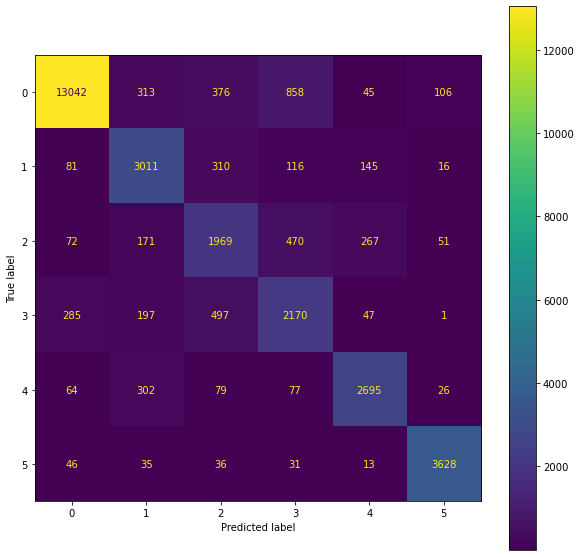

In [68]:
predictions = model.predict(X_test_scaled)

acc, balanced_acc = evaluate_model(y_test, predictions)
accuracies.append(acc)
balanced_accuracies.append(balanced_acc)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [69]:
print(feature_sets, accuracies, balanced_accuracies)

[['rms'], ['zc', 'ssc', 'wl'], ['zc', 'ssc', 'wl', 'mav'], ['zc', 'ssc', 'wl', 'rms'], ['zc', 'ssc', 'wl', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms'], ['zc', 'ssc', 'wl', 'mav', 'var'], ['zc', 'ssc', 'wl', 'rms', 'var'], ['zc', 'ssc', 'wl', 'mav', 'rms', 'var'], ['zc', 'ssc', 'wl', 'iemg', 'var', 'wamp'], ['skewness', 'rms', 'iemg', 'ar_coeff', 'hjorth'], ['mnf', 'mdf', 'mmnf', 'mmdf'], ['mnf', 'mdf'], ['mmnf', 'mmdf'], ['skewness', 'rms', 'iemg', 'ar_coeff', 'hjorth', 'mav', 'zc', 'ssc', 'wl']] [0.6644759708047647, 0.7327245726563241, 0.7625833359663813, 0.7677019811052482, 0.7669120667319662, 0.787386647287434, 0.7779392713829821, 0.7773073398843565, 0.7898195835571424, 0.783974217194856, 0.8375568756319515, 0.7089639483080035, 0.6350911561186767, 0.5327814464912004, 0.8378096562184024] [0.6234822969866917, 0.6546134173887808, 0.6962620102471676, 0.7056819054186084, 0.7009100500335649, 0.7275749797206159, 0.7235055676422003, 0.7155166314553347, 0.7333108558941959, 0.729459331341212, 0

In [70]:
np.save("feature_sets", np.array(feature_sets))
np.save("accuracies", np.array(accuracies))
np.save("balanced_accuracies", np.array(balanced_accuracies))

In [71]:
feature_sets = np.load("feature_sets.npy", allow_pickle=True).tolist()
accuracies = np.load("accuracies.npy", allow_pickle=True).tolist()
balanced_accuracies = np.load("balanced_accuracies.npy", allow_pickle=True).tolist()

## Feature Sets Accuracies

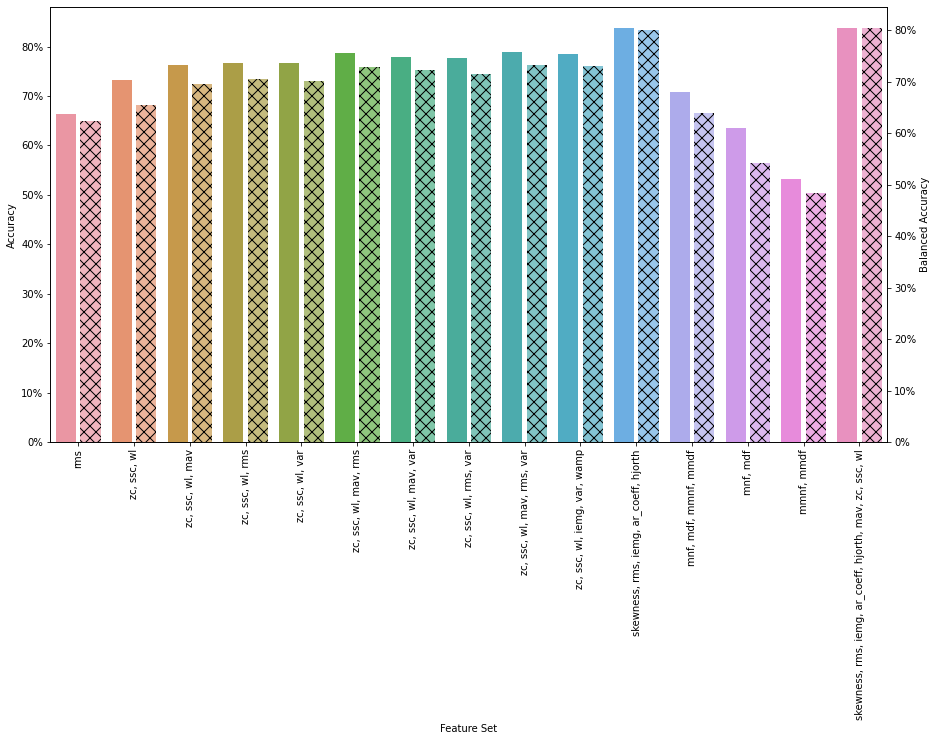

In [72]:
from matplotlib.ticker import PercentFormatter

results = pd.DataFrame({
    'Feature Set': [", ".join(ft) for ft in feature_sets],
    'Accuracy': accuracies,
    'Balanced Accuracy': balanced_accuracies
})

data1 = results[['Feature Set', 'Accuracy']]
data2 = results[['Feature Set', 'Balanced Accuracy']]

plt.figure(figsize=(15, 8))
width_scale = 0.45

ax = sns.barplot(x='Feature Set', y='Accuracy', data=data1)
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)

ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.tick_params(axis='x', rotation=90)

ax2 = ax.twinx()
sns.barplot(x='Feature Set', y='Balanced Accuracy', data=data2, alpha=0.7, hatch='xx', ax=ax2)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.tick_params(axis='x', rotation=90)

plt.show()

In [73]:
for fs, acc, bal_acc in zip(feature_sets, accuracies, balanced_accuracies):
    print("Feature Set: {0}   Accuracy: {1}   Balanced Accuracy: {2}".format(",".join(fs), acc*100, bal_acc*100))

Feature Set: rms   Accuracy: 66.44759708047647   Balanced Accuracy: 62.348229698669165
Feature Set: zc,ssc,wl   Accuracy: 73.27245726563241   Balanced Accuracy: 65.46134173887808
Feature Set: zc,ssc,wl,mav   Accuracy: 76.25833359663812   Balanced Accuracy: 69.62620102471676
Feature Set: zc,ssc,wl,rms   Accuracy: 76.77019811052482   Balanced Accuracy: 70.56819054186084
Feature Set: zc,ssc,wl,var   Accuracy: 76.69120667319662   Balanced Accuracy: 70.09100500335649
Feature Set: zc,ssc,wl,mav,rms   Accuracy: 78.7386647287434   Balanced Accuracy: 72.75749797206159
Feature Set: zc,ssc,wl,mav,var   Accuracy: 77.79392713829822   Balanced Accuracy: 72.35055676422003
Feature Set: zc,ssc,wl,rms,var   Accuracy: 77.73073398843565   Balanced Accuracy: 71.55166314553347
Feature Set: zc,ssc,wl,mav,rms,var   Accuracy: 78.98195835571424   Balanced Accuracy: 73.33108558941959
Feature Set: zc,ssc,wl,iemg,var,wamp   Accuracy: 78.3974217194856   Balanced Accuracy: 72.9459331341212
Feature Set: skewness,rms,

## DNN w/ Skewness/RMS/iEMG/AR(P=11) + Hjorth + MAV + ZC/SSC/WL Tuning

In [47]:
import keras_tuner as kt

In [48]:
feature_set = ["skewness", "rms", "iemg", "ar_coeff", "hjorth", "mav", "zc", "ssc", "wl"]
train_emg, test_emg, y_train, y_test = generate_dataset(data_dir, feature_set, win_size, win_stride)
X_train_scaled, X_test_scaled, y_train = transform_dataset(train_emg, test_emg, y_train)

Feature Extraction Time per Window:  0.44148439509166393
X_train shape: (72554, 42) y_train shape: (72554,)
X_test shape: (31649, 42) y_test shape: (31649,)


In [49]:
def model_builder(hp):
    model = keras.Sequential()

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units1, activation='relu'))
    model.add(layers.BatchNormalization())
    hp_dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.9, step=0.1)
    model.add(layers.Dropout(hp_dropout1))
    
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units2, activation='relu'))
    model.add(layers.BatchNormalization())
    hp_dropout2 = hp.Float('dropout2', min_value=0.1, max_value=0.9, step=0.1)
    model.add(layers.Dropout(hp_dropout2))
    
    hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units3, activation='relu'))
    model.add(layers.BatchNormalization())
    hp_dropout3 = hp.Float('dropout3', min_value=0.1, max_value=0.9, step=0.1)
    model.add(layers.Dropout(hp_dropout3))
    
    model.add(layers.Dense(6, activation="softmax"))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

In [50]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='tuned_model',
                     project_name='biosignal_analysis')

In [51]:
import tensorflow as tf

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [52]:
mlflow.start_run()

<ActiveRun: >

In [53]:
tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
Optimal number of units in the 1st densely-connected layer: {best_hps.get('units1')} 
Optimal number of units in the 2nd densely-connected layer: {best_hps.get('units2')}
Optimal number of units in the 3rd densely-connected layer: {best_hps.get('units3')}

Optimal dropout rate in the 1st densely-connected layer: {best_hps.get('dropout1')} 
Optimal dropout rate in the 2nd densely-connected layer: {best_hps.get('dropout2')}
Optimal dropout rate in the 3rd densely-connected layer: {best_hps.get('dropout3')}

Optimal learning rate for the optimizer: {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 01m 27s]
val_accuracy: 0.8299567699432373

Best val_accuracy So Far: 0.8560237884521484
Total elapsed time: 00h 15m 42s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
Optimal number of units in the 1st densely-connected layer: 128 
Optimal number of units in the 2nd densely-connected layer: 192
Optimal number of units in the 3rd densely-connected layer: 320

Optimal dropout rate in the 1st densely-connected layer: 0.2 
Optimal dropout rate in the 2nd densely-connected layer: 0.5
Optimal dropout rate in the 3rd densely-connected layer: 0.1

Optimal learning rate for the optimizer: 0.001.



In [54]:
mlflow.log_param("l1_neurons", best_hps.get('units1'))
mlflow.log_param("l2_neurons", best_hps.get('units2'))
mlflow.log_param("l3_neurons", best_hps.get('units3'))
mlflow.log_param("l1_dropout_rate", best_hps.get('dropout1'))
mlflow.log_param("l2_dropout_rate", best_hps.get('dropout2'))
mlflow.log_param("l3_dropout_rate", best_hps.get('dropout3'))
mlflow.log_param("learning_rate", best_hps.get('learning_rate'))

In [55]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
926/926 [==============================] - 7s 6ms/step - loss: 0.9360 - accuracy: 0.6534 - val_loss: 0.6317 - val_accuracy: 0.7719
Epoch 2/50
926/926 [==============================] - 5s 5ms/step - loss: 0.7152 - accuracy: 0.7340 - val_loss: 0.5413 - val_accuracy: 0.8067
Epoch 3/50
926/926 [==============================] - 8s 8ms/step - loss: 0.6479 - accuracy: 0.7654 - val_loss: 0.5061 - val_accuracy: 0.8202
Epoch 4/50
926/926 [==============================] - 6s 6ms/step - loss: 0.5970 - accuracy: 0.7850 - val_loss: 0.4579 - val_accuracy: 0.8424
Epoch 5/50
926/926 [==============================] - 8s 8ms/step - loss: 0.5653 - accuracy: 0.7995 - val_loss: 0.4388 - val_accuracy: 0.8520
Epoch 6/50
926/926 [==============================] - 7s 8ms/step - loss: 0.5442 - accuracy: 0.8070 - val_loss: 0.4202 - val_accuracy: 0.8553
Epoch 7/50
926/926 [==============================] - 8s 8ms/step - loss: 0.5281 - accuracy: 0.8137 - val_loss: 0.4013 - val_accuracy: 0.8641
Epoch 

In [56]:
mlflow.log_param("epochs", best_epoch)

In [58]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_hist = hypermodel.fit(X_train_scaled, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/48
926/926 [==============================] - 6s 5ms/step - loss: 0.9328 - accuracy: 0.6540 - val_loss: 0.6204 - val_accuracy: 0.7740
Epoch 2/48
926/926 [==============================] - 5s 6ms/step - loss: 0.7187 - accuracy: 0.7322 - val_loss: 0.5452 - val_accuracy: 0.8021
Epoch 3/48
926/926 [==============================] - 6s 7ms/step - loss: 0.6427 - accuracy: 0.7647 - val_loss: 0.4917 - val_accuracy: 0.8198
Epoch 4/48
926/926 [==============================] - 5s 5ms/step - loss: 0.5980 - accuracy: 0.7863 - val_loss: 0.4539 - val_accuracy: 0.8470
Epoch 5/48
926/926 [==============================] - 7s 7ms/step - loss: 0.5668 - accuracy: 0.7975 - val_loss: 0.4354 - val_accuracy: 0.8502
Epoch 6/48
926/926 [==============================] - 6s 6ms/step - loss: 0.5427 - accuracy: 0.8079 - val_loss: 0.4143 - val_accuracy: 0.8635
Epoch 7/48
926/926 [==============================] - 7s 8ms/step - loss: 0.5275 - accuracy: 0.8157 - val_loss: 0.4103 - val_accuracy: 0.8606
Epoch 

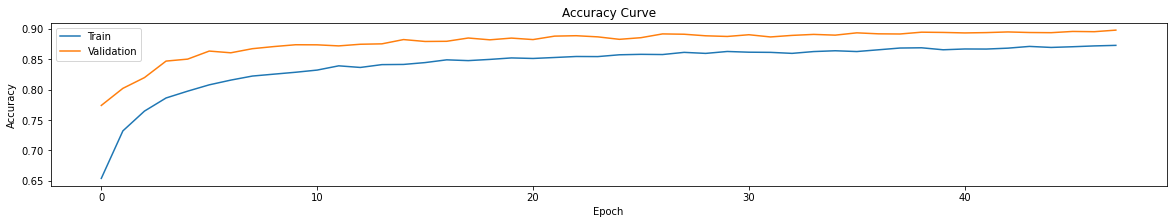

In [59]:
plt.plot(hypermodel_hist.history['accuracy'])
plt.plot(hypermodel_hist.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(["Train", "Validation"])

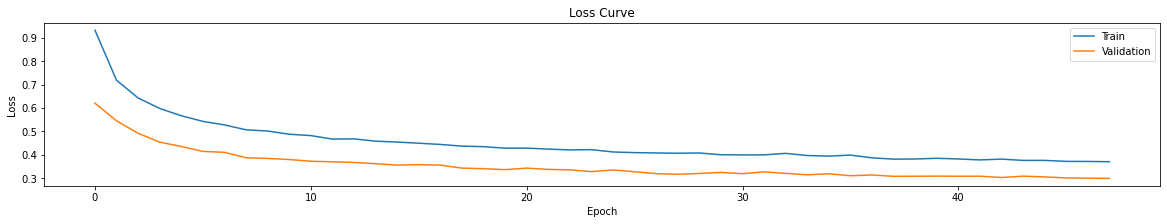

In [60]:
plt.plot(hypermodel_hist.history['loss'])
plt.plot(hypermodel_hist.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend(["Train", "Validation"])

In [61]:
mlflow.sklearn.log_model(hypermodel, "dnn_model")

INFO:tensorflow:Assets written to: ram://06aed531-3a0b-4031-bbef-500b664080eb/assets


2022/04/25 04:08:34 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Hagar\AppData\Local\Temp\tmpfbibdrf6\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


ModelInfo(artifact_path='dnn_model', flavors={'python_function': {'model_path': 'model.pkl', 'loader_module': 'mlflow.sklearn', 'python_version': '3.9.7', 'env': 'conda.yaml'}, 'sklearn': {'pickled_model': 'model.pkl', 'sklearn_version': '1.0.2', 'serialization_format': 'cloudpickle'}}, model_uri='runs:/0722f7bdaf9e466fb464685350b3946b/dnn_model', model_uuid='52014c4cbec44dba8b8f2c7f63c0342a', run_id='0722f7bdaf9e466fb464685350b3946b', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-04-25 02:07:40.036228')

In [62]:
pkl.dump(hypermodel, open('dnn_model.sav', 'wb'))

INFO:tensorflow:Assets written to: ram://75f135bc-4d82-448f-8c3b-1a0d823c3387/assets


## Test Feature Extraction + Prediction Time

Prediction Time per Window:  0.07083009984833165
Test Accuracy: 0.8446979271991911 Balanced Test Accuracy: 0.8194669104988116
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     14740
           1       0.76      0.85      0.80      3679
           2       0.63      0.66      0.64      3000
           3       0.60      0.72      0.65      3197
           4       0.84      0.86      0.85      3243
           5       0.94      0.96      0.95      3789

    accuracy                           0.84     31648
   macro avg       0.79      0.82      0.80     31648
weighted avg       0.86      0.84      0.85     31648



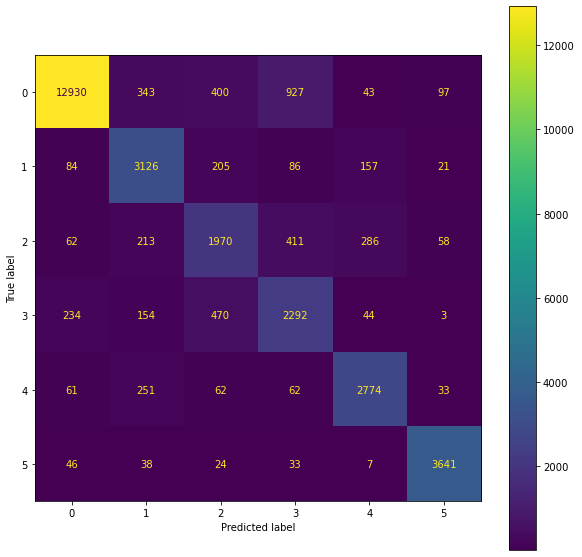

In [63]:
start = datetime.now()
predictions = hypermodel.predict(X_test_scaled)
end = datetime.now()

print("Prediction Time per Window: ", ((end-start).total_seconds()*1000)/predictions.shape[0])

acc, balanced_acc = evaluate_model(y_test, predictions)
print(f"Test Accuracy: {acc} Balanced Test Accuracy: {balanced_acc}")

plot_results(y_test, predictions)

In [64]:
mlflow.log_metric("accuracy", acc)
mlflow.log_metric("balanced_accuracy", balanced_acc)

In [67]:
Total_time = 0.44148439509166393 + 0.07083009984833165
print("Total Time: ", Total_time)

Total Time:  0.5123144949399956
